### GENERATING THE DATA TO TRAIN DE MODEL

Randomly produce "brush strokes" matrices with 3 + 1 dimensions:

* D1 Height
* D2 Width
* D3 RGB color codification 
* D4 Depth : which will codify the layer in the picture, from 0 to N_layers

Notes: H & W could be fixed to certain values although higher enough to be able to capture enough information later (check this out) 
 
Layers: When assigning layers, there is no need to increase the number of the layer if there is not overlap on a previous layer. The number of layer should be the max(previous layers overlaped by the actual "brush stroke") + 1.



(note: the input data could be also a section of any of the original items produced)


## 1- Generating the brush-strokes data base

from pictures with many brush strokes, extract each individual stroke and save them in separated files.



### Funcion:
- input 
    - fichero del que extraer brushes, 
- output 
    - fichero con contours detectados
    - fichero/s con brush strokes unitarios




In [18]:
import cv2
import numpy as np
#import matplotlib.pyplot as plt


# if does not exist, add the folders structure to work

#./data
#     /brush_stroke
#                  /00_bs_db      (bs data base) 
#                  /01_contours   (for info)

In [64]:
def extract_brushes(path, nameInFile, nameOutContFile):
    
    image = cv2.imread(path + nameInFile)
    
    red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2] 
    mask_white = (red >=200) & (green >=200) & (blue >=200)
    mask_black= ~mask_white
    image[:,:,:3][mask_white]=[255,255,255]
    image[:,:,:3][mask_black]=[0,0,0]
    #plt.imshow(image)
    #plt.show()
    image = (255-image)    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #to gray scale
    #plt.imshow(gray)
    #plt.show()

    scale_percent= 600/gray.shape[1] #percent of established width in order to have all inputs in same scale for a later application a minimum area

    width = int(gray.shape[1] * scale_percent )
    height = int(gray.shape[0] * scale_percent )

    # resize image
    gray = cv2.resize(gray, (width, height))
    image = cv2.resize(image, (width, height))
    image0 = image.copy()
    #print("gray")
    #plt.imshow(gray)
    #plt.show()
    #print("image0")
    #plt.imshow(image)
    #plt.show()

    # elimino este transformacion (canny), demasiado accurate y da lugar a open contours
    #canny = cv2.Canny(gray, 10, 150)
    #canny = cv2.dilate(canny, None, iterations=1)
    #canny = cv2.erode(canny, None, iterations=1)
    #print("canny")
    #plt.imshow(canny)
    #plt.show()
  
    contours,hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    threshold_area =75  
    
    new_contours=[]    

    for i,cnt in enumerate(contours):        
        area = cv2.contourArea(cnt)         

        if area > threshold_area:             
            new_contours.append(cnt)
            cv2.drawContours(image, contours,i, (0,255,0), 3)  # se marcan los contours en verde
            
    path_contours=path + '01_contours/'
    cv2.imwrite(path_contours + nameOutContFile, image) # almacenamos en un fichero la salida para seguimiento-validación    
    
    #print(len(new_contours))
    
    # extraer cada pincelada por separado en un fichero
    idx_out=1 #generador de idx para los brush strokes finales, que componen la ddbb
    for idx in range(len(new_contours)):
        image_i=image0.copy() #actuamos sobre una copia   
        
        #red, green, blue = image_i[:,:,0], image_i[:,:,1], image_i[:,:,2] 
        #mask_white = (red >=200) & (green >=200) & (blue >=200)
        #mask_black= ~mask_white
        #image_i[:,:,:3][mask_white]=[255,255,255]
        #image_i[:,:,:3][mask_black]=[0,0,0]
        
        mask_i = np.zeros_like(image_i) # Create mask where white is what we want, black otherwise
        cv2.drawContours(mask_i, new_contours, idx, (255,255,255), -1) # Draw filled contour in mask
        out_i = np.zeros_like(image_i)   # Extract out the object and place into output image
        out_i[mask_i == 255] = image_i[mask_i == 255]
        #plt.imshow(out_i)
        #plt.show()
        #crop out____________________________________________
        
        (x, y) = np.where((mask_i[:, :, 0]==255) & (mask_i[:, :, 1]==255) & (mask_i[:, :, 2]==255))

        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        
        height=bottomy-topy
        width=bottomx-topx

        brush = out_i[topx: topx + width,topy: topy + height]
        
        path_brushes=path + '00_bs_db/'
        cv2.imwrite(path_brushes + "bsu_" + ("0"*4 + str(idx_out))[-5:] + ".jpg", brush)
        
        idx_out+=1    
               
    
    
    return

In [65]:
# generating the ddbb of brush strokes #
#-----------------------------------#

path_bs='./data/brush_strokes/'

for idfile in range(24):
    #id del fichero
    file_n=("0" + str(idfile + 1))[-2:]
    
    
    file_is =  "bs_{}.jpg".format(file_n)
    file_tobe =  "bs_{}_contours.jpg".format(file_n )
    
    extract_brushes(path_bs,file_is,file_tobe)   
    

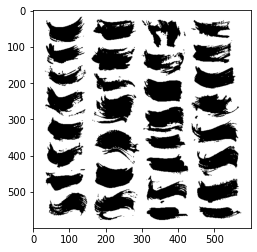

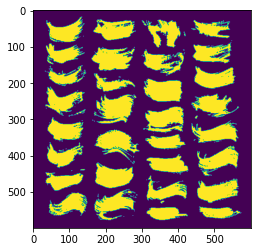

gray


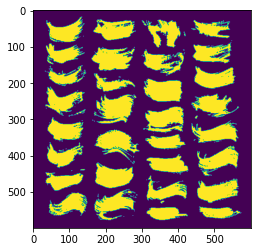

image0


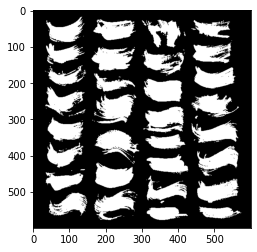

canny


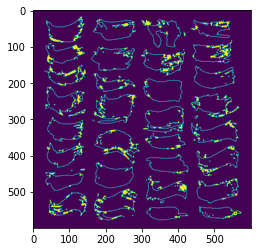

31


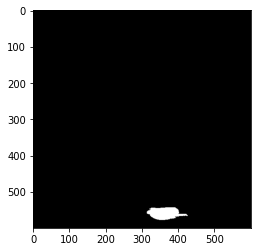

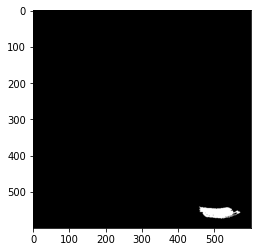

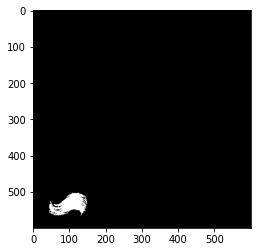

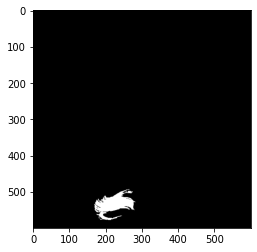

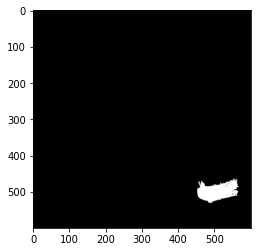

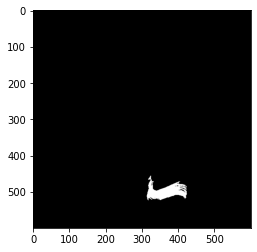

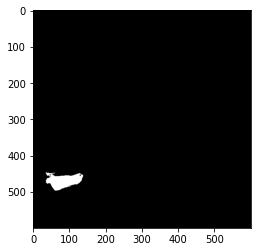

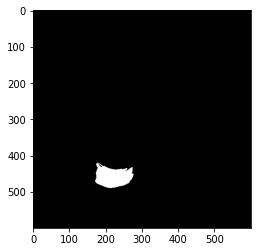

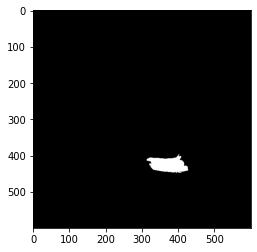

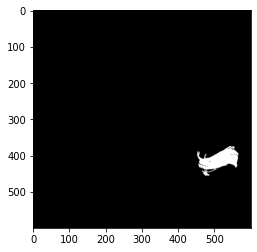

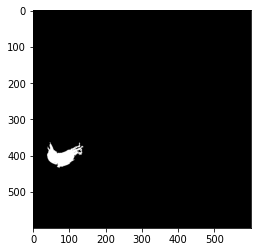

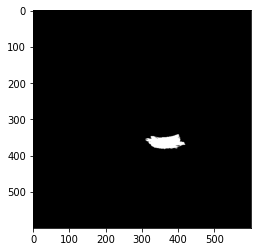

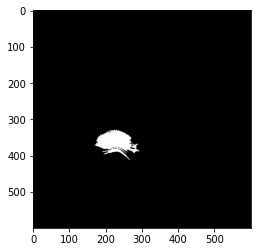

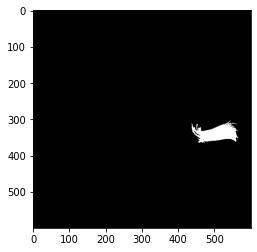

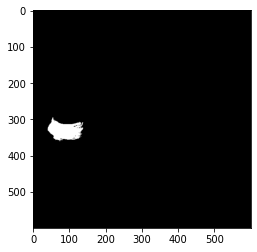

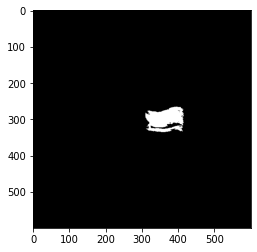

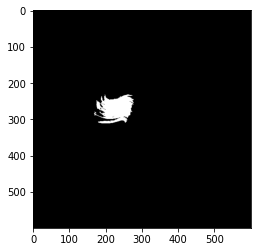

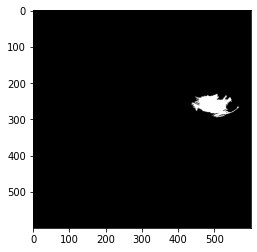

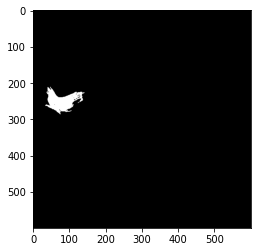

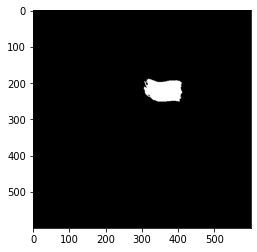

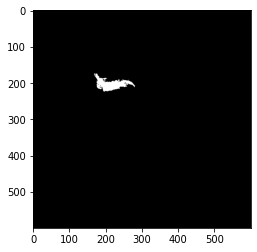

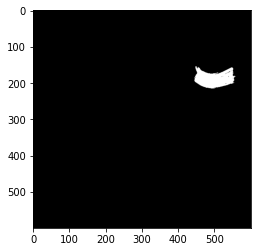

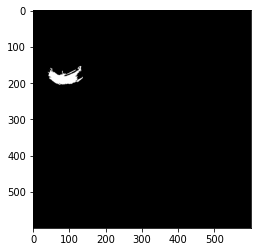

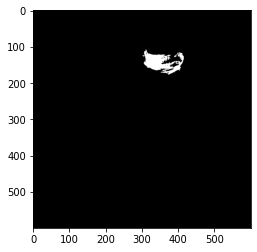

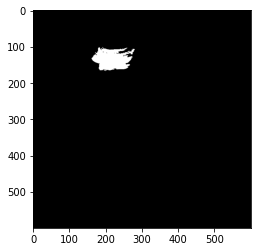

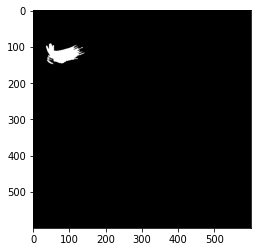

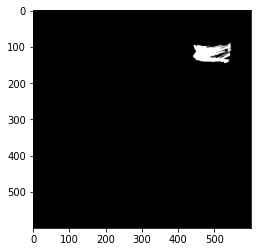

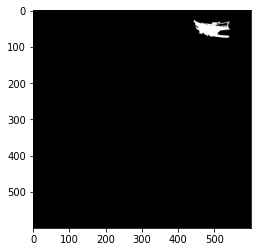

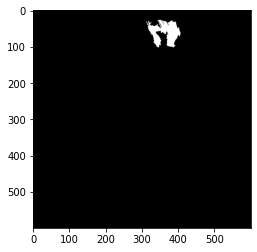

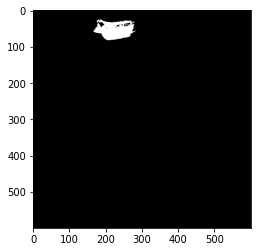

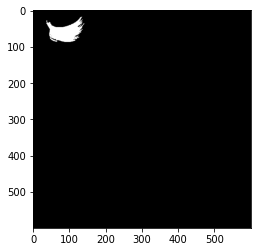

In [63]:
#individual test

path_bs='./data/brush_strokes/'

extract_brushes(path_bs, "bs_01.jpg", "bs_01_contours.jpg")
#extract_contours_v2(path_bs,1, "bs_01.jpg","bs_01_contours2.jpg")

#extract_brushes(path_bs, "foto_01.jpg", "foto_01_out.jpg")

# Notes to delete later ______ ______ ______ ______ ______ ______ ______ ______ ______ ______

### Nota1: 
Se pueden incluir pinceladas desde fotografias. Puedo crear mi propia base de datos de pinceladas, pintándolas.

De estas páginas se pueden extraer brush strokes, utilizarlas para la v final

https://stock.adobe.com/es/search?filters%5Bcontent_type%3Aphoto%5D=1&filters%5Bcontent_type%3Aillustration%5D=1&filters%5Bcontent_type%3Azip_vector%5D=1&filters%5Bcontent_type%3Avideo%5D=1&filters%5Bcontent_type%3Atemplate%5D=1&filters%5Bcontent_type%3A3d%5D=1&filters%5Bcontent_type%3Aaudio%5D=0&filters%5Binclude_stock_enterprise%5D=0&filters%5Bis_editorial%5D=0&filters%5Bfree_collection%5D=0&order=relevance&serie_id=189411385&continue-checkout=1


https://www.vecteezy.com/vector-art/4246949-brush-strokes-bundle-vector-paintbrush-set-round-frames-set-of-strokes-grunge-brush-stroke



### Nota2:
Si todos los orígenes de datos son del mismo tamaño, no habrá problemas con el formateo, de lo contrario, se encuentran parámetros que tienen sentido para unas fotos mas que otras, como la limitación del area al definir contours.

### Nota3:
Los siguientes códigos están pendientes de descartar. Revisar en una segunda vuelta
    

In [ ]:
# before sending it to the bin, check the thresh functionality for the actual project

def extract_contours_v2(path, nfile, nameInFile, nameOutContFile):
    
    image = cv2.imread(path + nameInFile)
    image = (255-image)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #to gray scale
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh  = cv2.threshold(blur, 225, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
   
    scale_percent= 800/thresh.shape[1] #percent of established width in order to have all inputs in same scale for a later application a minimum area

    width = int(thresh.shape[1] * scale_percent )
    height = int(thresh.shape[0] * scale_percent )

    # resize image
    thresh = cv2.resize(thresh, (width, height))
    image = cv2.resize(image, (width, height))
    image0 = image.copy()

    canny = cv2.Canny(thresh, 10, 150)
    canny = cv2.dilate(canny, None, iterations=1)
    canny = cv2.erode(canny, None, iterations=1)  
    
  
    contours,hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    threshold_area = 100  
    
    new_contours=[]    

    for i,cnt in enumerate(contours):        
        area = cv2.contourArea(cnt)         

        if area > threshold_area:             
            new_contours.append(cnt)
            cv2.drawContours(image, contours,i, (0,255,0), 3)  # se marcan los contours en verde

    cv2.imwrite(path + nameOutContFile, image) # almacenamos en un fichero la salida para seguimiento-validación    
    
    
    # version a revisar en una segunda vuelta. Ha sido descartado el thresh. Genera contours mas complicados
    # que no ayudan a resolver el problema inicial
      
    
    return

In [ ]:
# comprobar si este código enriquece en algo la obtención de pinceladas

import cv2
import numpy as np
from PIL import Image

path_bs='./data/brush_strokes/'

def crop_char(image, name):
    # Load image, convert to grayscale, Gaussian blur, Otsu's threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
# Filter using contour area and remove small noise
    cnts,_ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, cnts, -1, (0,255,0), 3)
    
    #cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        #size of the countours to remove
        if area  < 100:
            #cv2.drawContours(thresh, [c], -1, (0,0,0), -1)
            a=1
# Invert image
    # results a clean noise free grid
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    image_inv = cv2.bitwise_not(thresh)
    
    cv2.imwrite(path_bs + name + "_thresh.jpg", thresh)
    cv2.imwrite(path_bs + name + "_inverted.jpg", image_inv)

 


#set image
img = cv2.imread(path_bs + "foto_02.jpg")
crop_char(img, 'foto02')
